## Data Loading

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import time
import pickle
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add

In [80]:
#Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [81]:
captions = readTextFile("Flickr8K Dataset/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

In [82]:
captions = captions.split("\n")[:-1]
len(captions)

40460

In [83]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [84]:
#Dictionary to map each image with a list of its captions
descriptions = {}

for x in captions:
    first, second = x.split("\t")
    img_name = first.split(".")[0]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    descriptions[img_name].append(second)

In [85]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Data Cleaning

In [86]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " ", sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [87]:
#Clean all captions
for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [88]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [89]:
#Write the data to a text file
with open("descriptions.txt", "w") as f:
    f.write(str(descriptions))

## Vocabulary Creation

In [91]:
descriptions = None
with open("descriptions.txt") as f:
    descriptions = f.read()

#To convert descriptions from str to dict
json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [92]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

In [93]:
len(vocab)

8424

In [94]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

In [95]:
len(total_words)

373837

In [96]:
import collections
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(freq_cnt)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [97]:
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [98]:
len(total_words)

1845

## Train-Test Data Preparation 

In [99]:
train_file_data = readTextFile("Flickr8K Dataset/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Flickr8K Dataset/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [100]:
print(train_file_data)

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
488416045_1c6d903fe0.jpg
2644326817_8f45080b87.jpg
218342358_1755a9cce1.jpg
2501968935_02f2cd8079.jpg
2699342860_5288e203ea.jpg
2638369467_8fc251595b.jpg
2926786902_815a99a154.jpg
2851304910_b5721199bc.jpg
3423802527_94bd2b23b0.jpg
3356369156_074750c6cc.jpg
2294598473_40637b5c04.jpg
1191338263_a4fa073154.jpg
2380765956_6313d8cae3.jpg
3197891333_b1b0fd1702.jpg
3119887967_271a097464.jpg
2276499757_b44dc6f8ce.jpg
2506892928_7e79bec613.jpg
2187222896_c206d63396.jpg
2826769554_85c90864c9.jpg
3097196395_ec06075389.jpg
3603116579_4a28a932e2.jpg
3339263085_6db9fd0981.jpg
2532262109_87429a2cae.jpg
2076906555_c20dc082db.jpg
2502007071_82a8c639cf.jpg
3113769557_9edbb8275c.jpg
3325974730_3ee192e4ff.jpg
1655781989_b15ab4cbff.jpg
1662261486_db967930de.jpg
2410562803_56ec09f41c.jpg
2469498117_b4543e1460.jpg
69710415_5c2bfb1058.jpg
3414734842_beb543f400.jpg
3006217970_90b42e6b27.jpg
2192411521_9c7e488c5e.jpg
3535879138_9281d

In [101]:
train =[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
print(train[:5])
test =[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']


In [102]:
#Prepare descriptions for training data
#Add <s> and <e> tokens to the training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [103]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Data Preprocessing using Transfer Learning

#### i) Conversion of Images to ResNet50 Feature Vectors

In [104]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [105]:
model_new = Model(model.input, model.layers[-2].output)

In [106]:
def preprocess_img(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0) #To reshape img from (224, 224, 3) to (1,224,224,3)
    #Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


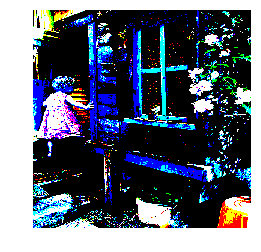

In [107]:
img = preprocess_img("Flickr8K Dataset/Flickr_Data/Images/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [108]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [51]:
start = time()

#Dictionary to map training image id to its feature vector
encoding_train = {}
for ix, img_id in enumerate(train):
    img_path = "Flickr8K Dataset/Flickr_Data/Images/" + img_id + ".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in progress. Time step = %d" %ix)
        
end = time()
print("Total time taken :", end-start)

Encoding in progress. Time step = 0
Encoding in progress. Time step = 100
Encoding in progress. Time step = 200
Encoding in progress. Time step = 300
Encoding in progress. Time step = 400
Encoding in progress. Time step = 500
Encoding in progress. Time step = 600
Encoding in progress. Time step = 700
Encoding in progress. Time step = 800
Encoding in progress. Time step = 900
Encoding in progress. Time step = 1000
Encoding in progress. Time step = 1100
Encoding in progress. Time step = 1200
Encoding in progress. Time step = 1300
Encoding in progress. Time step = 1400
Encoding in progress. Time step = 1500
Encoding in progress. Time step = 1600
Encoding in progress. Time step = 1700
Encoding in progress. Time step = 1800
Encoding in progress. Time step = 1900
Encoding in progress. Time step = 2000
Encoding in progress. Time step = 2100
Encoding in progress. Time step = 2200
Encoding in progress. Time step = 2300
Encoding in progress. Time step = 2400
Encoding in progress. Time step = 250

In [52]:
#Store computed feature vectors to the disk
with open("encoded_train_features.pkl", "wb") as f:
    pickle.dump(encoding_train, f)

In [53]:
start = time()

#Dictionary to map test image id to its feature vector
encoding_test = {}
for ix, img_id in enumerate(test):
    img_path = "Flickr8K Dataset/Flickr_Data/Images/" + img_id + ".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in progress. Time step = %d" %ix)
        
end = time()
print("Total time taken :", end-start)

Encoding in progress. Time step = 0
Encoding in progress. Time step = 100
Encoding in progress. Time step = 200
Encoding in progress. Time step = 300
Encoding in progress. Time step = 400
Encoding in progress. Time step = 500
Encoding in progress. Time step = 600
Encoding in progress. Time step = 700
Encoding in progress. Time step = 800
Encoding in progress. Time step = 900
Total time taken : 76.80449271202087


In [54]:
with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)

In [109]:
with open("encoded_train_features.pkl", "rb") as f:
    pickle.load(f)
with open("encoded_test_features.pkl", "rb") as f:
    pickle.load(f)

#### ii)Conversion of Words of Captions into Glove Vectors 

In [110]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(total_words):
    word_to_idx[word] = i+1         #i+1 because index 0 is reserved for every word in a sentence after <e>
    idx_to_word[i+1] = word

In [111]:
print(len(idx_to_word))

1845


In [112]:
print(len(word_to_idx))

1845


In [113]:
#Addition of <s> and <e> to dictionary
idx_to_word[1846] = "startseq"
word_to_idx["startseq"] = 1846

idx_to_word[1847] = "endseq"
word_to_idx["endseq"] = 1847

vocab_size = len(word_to_idx)+1
print(vocab_size)

1848


In [114]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))
print(max_len)

35


In [115]:
f = open("glove.6B.50d.txt", encoding="utf-8")

In [116]:
#Dictionary to map word to its glove vector
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:], dtype="float")
    embedding_index[word] = word_embedding

In [117]:
f.close()

In [118]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [119]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

## Data Generator

In [134]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    X1, X2, y = [], [], []
    
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]

                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]

                    #0 denotes padding word
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding="post")[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
            
                if n==batch_size:
                    yield [np.array(X1), np.array(X2)], np.array(y)
                    X1, X2, y = [], [], []
                    n=0

## Model Construction

In [147]:
#Process Images
input_img_features = Input(shape=(2048,), name="image_input")
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation="relu")(inp_img1)

In [148]:
#LSTM to Process Captions
input_captions = Input(shape=(max_len,), name="caption_input")
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [149]:
#MLP (Feed Forward NN) 
decoder1 =  add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation="relu")(decoder1)
output = Dense(vocab_size, activation="softmax")(decoder2)

In [150]:
#Combining the model
model = Model(inputs=[input_img_features, input_captions], outputs=output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caption_input (InputLayer)      (None, 35)           0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 50)       92400       caption_input[0][0]              
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           image_input[0][0]                
____________________________________________________________________________________________

In [151]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [152]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

## Model Training

In [140]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [142]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)                                     
    model.save("./model_weights/model_"+str(i)+".h5")

'for i in range(epochs):\n    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)\n    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)                                     \n    model.save("./model_weights/model_"+str(i)+".h5")'

In [201]:
model.load_weights('./model_weights/model_19.h5')

## Prediction

In [221]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax() #Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (" "+word)
        if word=="endseq":
            break
            
    final_caption = in_text.split()[1:-1]
    final_caption = " ".join(final_caption)
    return final_caption

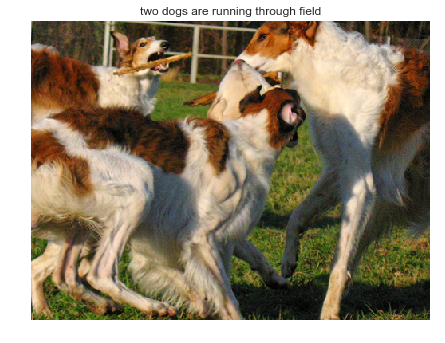

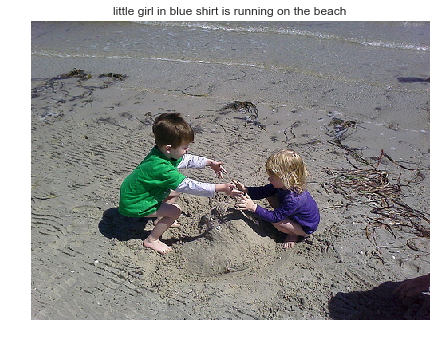

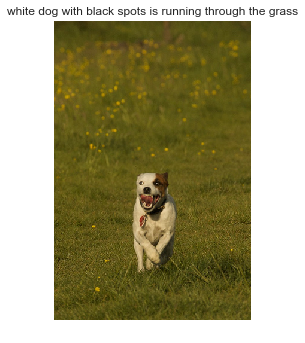

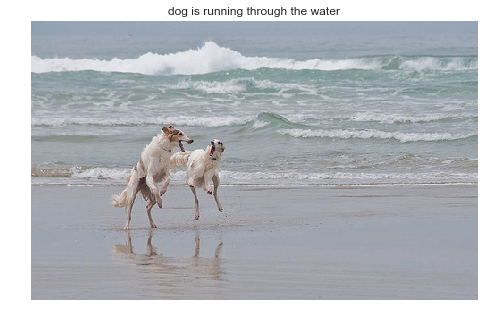

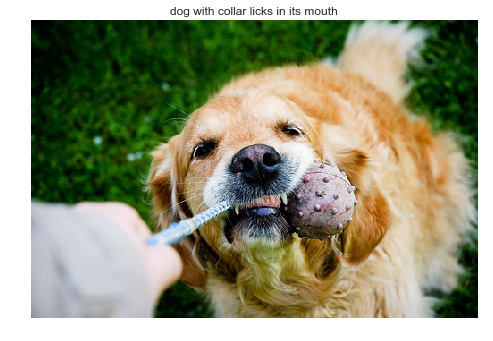

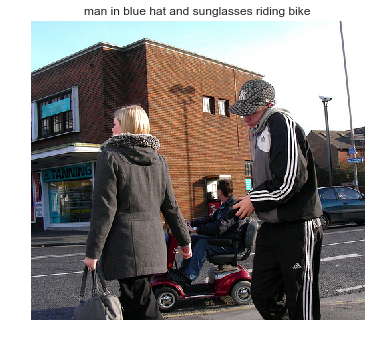

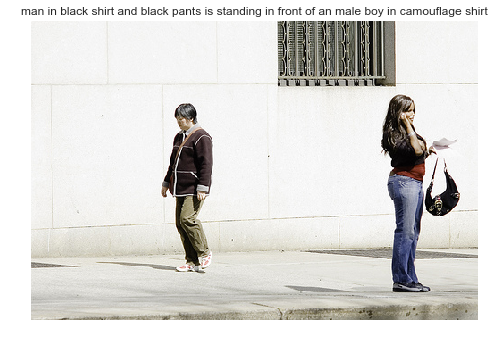

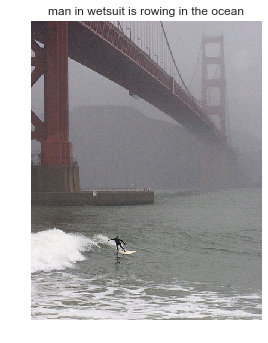

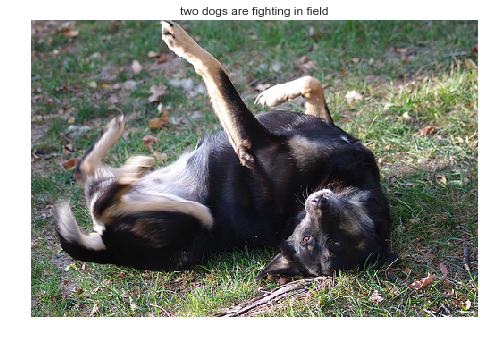

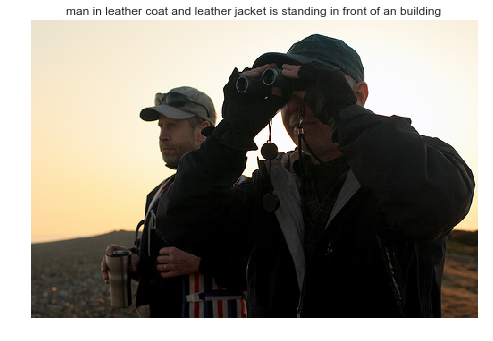

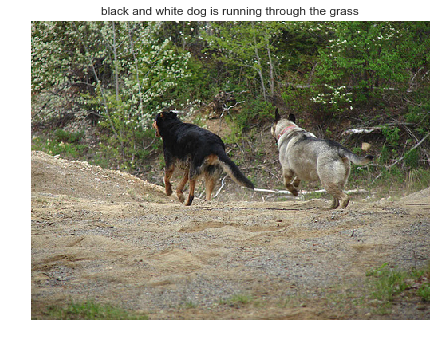

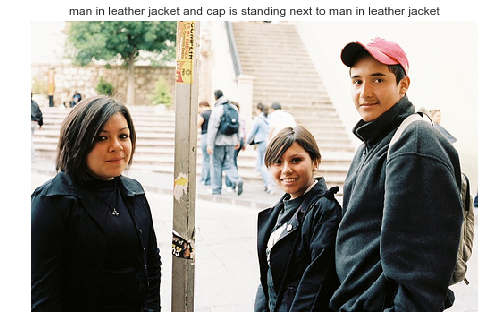

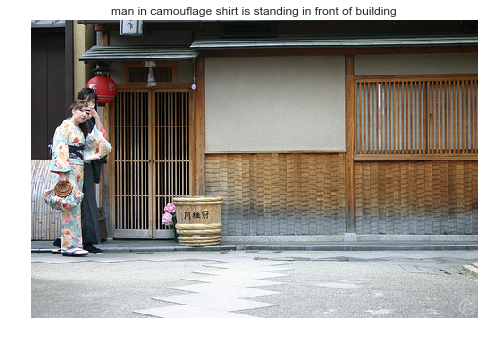

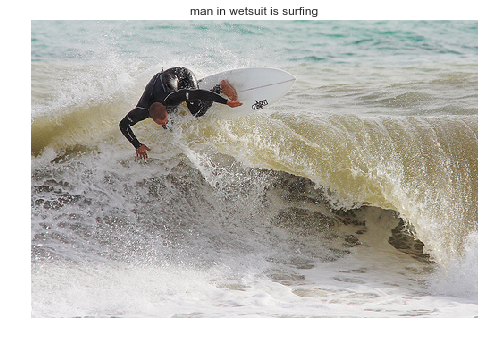

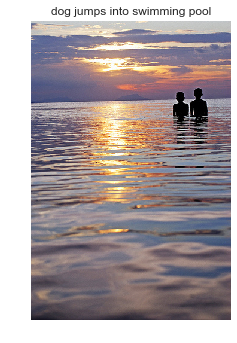

In [222]:
#Pick some random images and see results
for i in range(15):
    idx = np.random.randint(0, 1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1, 2048))
    
    i = plt.imread("Flickr8K Dataset/Flickr_Data/Images/"+img_name+".jpg")
    caption = predict_caption(photo_2048)
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()